### updaload kaggle api

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d renancostaalencar/compcars

Dataset URL: https://www.kaggle.com/datasets/renancostaalencar/compcars
License(s): unknown
100% 15.4G/15.4G [14:01<00:00, 25.4MB/s]
100% 15.4G/15.4G [14:01<00:00, 19.6MB/s]


In [3]:
!unzip /content/compcars.zip


Streaming output truncated to the last 5000 lines.
  inflating: part/77/159/2010/2/510208d2e16924.jpg  
  inflating: part/77/159/2010/3/56b85f75643fcd.jpg  
  inflating: part/77/159/2010/3/6ce67ffc8ee4f5.jpg  
  inflating: part/77/159/2010/4/361ab40804d981.jpg  
  inflating: part/77/159/2010/4/de3c9b5bbb5827.jpg  
  inflating: part/77/159/2010/5/c2c25e35071415.jpg  
  inflating: part/77/159/2010/5/da03fe61f467dd.jpg  
  inflating: part/77/159/2010/6/8fca577c2ba86d.jpg  
  inflating: part/77/159/2010/6/c2e58551864677.jpg  
  inflating: part/77/159/2010/7/5e9e144e050cf0.jpg  
  inflating: part/77/159/2010/7/e1696de65b0894.jpg  
  inflating: part/77/159/2010/8/062e405280e0c7.jpg  
  inflating: part/77/159/2011/1/0ff534924111a2.jpg  
  inflating: part/77/159/2011/1/5d30d1747dab22.jpg  
  inflating: part/77/159/2011/1/af5c5af5fce90e.jpg  
  inflating: part/77/159/2011/2/53c97dde48ed13.jpg  
  inflating: part/77/159/2011/2/5ccf0d0f2365d4.jpg  
  inflating: part/77/159/2011/2/9fccfa83a7d71f.j

### Import needed libraries

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint




##Preprocess and Visualize dataset

In [5]:
from sklearn.model_selection import train_test_split

def read_verification_file(filepath):
    input1 = []
    input2 = []
    labels = []

    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            img1_path, img2_path, label = line.strip().split(' ')
            input1.append(img1_path)
            input2.append(img2_path)
            labels.append(int(label))

    return input1, input2, labels

# Example usage
input1, input2, labels = read_verification_file('train_test_split/verification/verification_pairs_easy.txt')

# Split into train, validation, and test sets (e.g., 60% train, 20% validation, 20% test)
# First split: 80% train+val, 20% test
input1_train_val, input1_test, input2_train_val, input2_test, labels_train_val, labels_test = train_test_split(
    input1, input2, labels, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (of the remaining 80%)
input1_train, input1_val, input2_train, input2_val, labels_train, labels_val = train_test_split(
    input1_train_val, input2_train_val, labels_train_val, test_size=0.25, random_state=42)

# At this point:
# input1_train, input2_train, labels_train -> training set
# input1_val, input2_val, labels_val -> validation set
# input1_test, input2_test, labels_test -> test set

print(f"Training pairs: {len(input1_train)}, Validation pairs: {len(input1_val)}, Test pairs: {len(input1_test)}")



Training pairs: 12000, Validation pairs: 4000, Test pairs: 4000


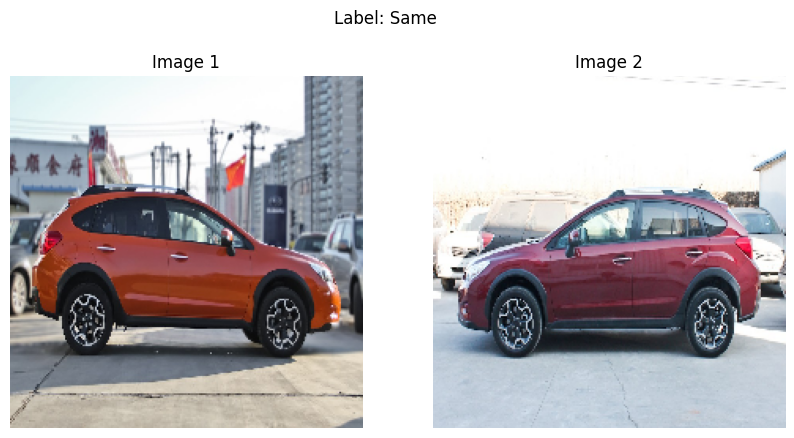

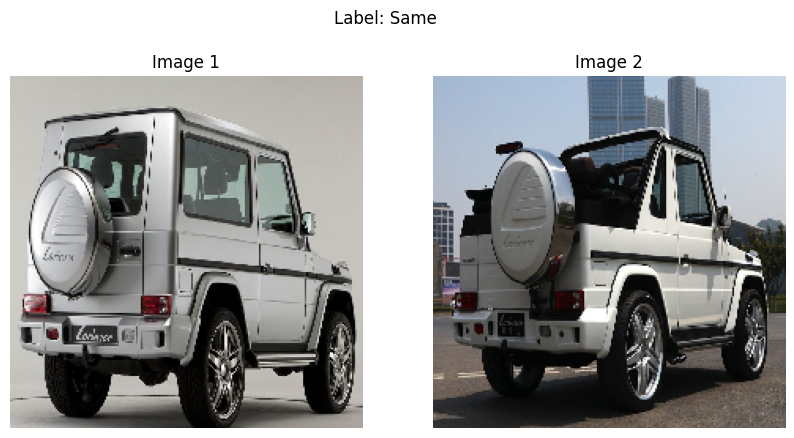

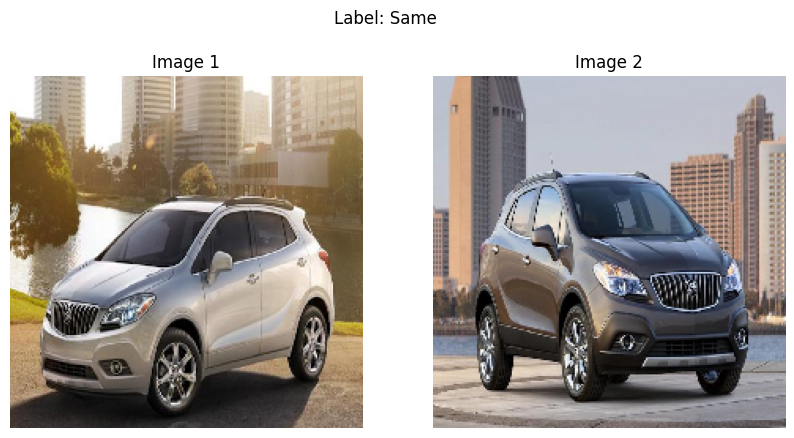

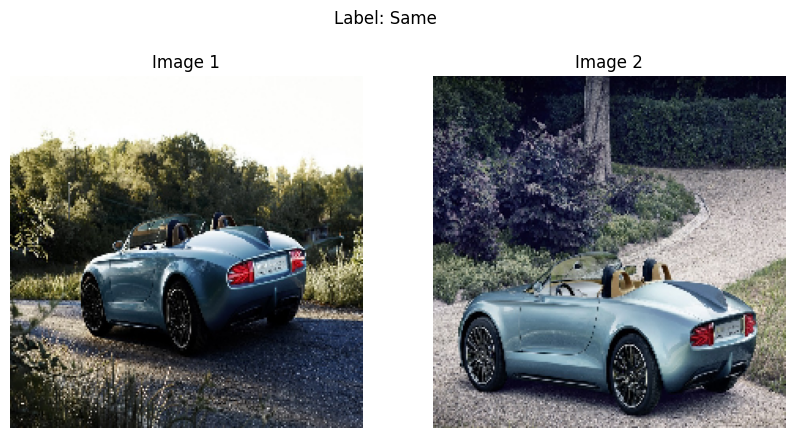

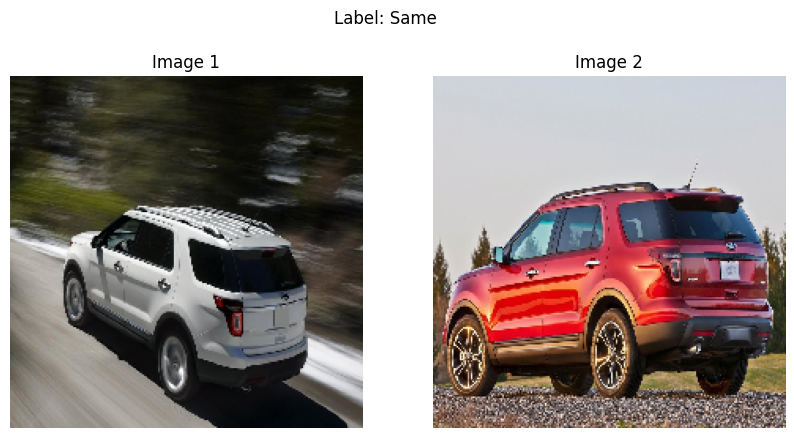

In [6]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Function to display image pairs
def display_image_pair(img1_path, img2_path, label):
    img1 = load_img(os.path.join('image', img1_path), target_size=(224, 224))
    img2 = load_img(os.path.join('image', img2_path), target_size=(224, 224))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Image 1')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('Image 2')

    plt.suptitle(f'Label: {"Same" if label == 1 else "Different"}')
    plt.show()

# Function to visualize random image pairs
def visualize_random_pairs(input1, input2, labels, num_pairs=5):
    indices = random.sample(range(len(input1)), num_pairs)
    for idx in indices:
        img1_path = input1[idx]
        img2_path = input2[idx]
        label = labels[idx]
        display_image_pair(img1_path, img2_path, label)

# Example usage:
visualize_random_pairs(input1, input2, labels, num_pairs=5)


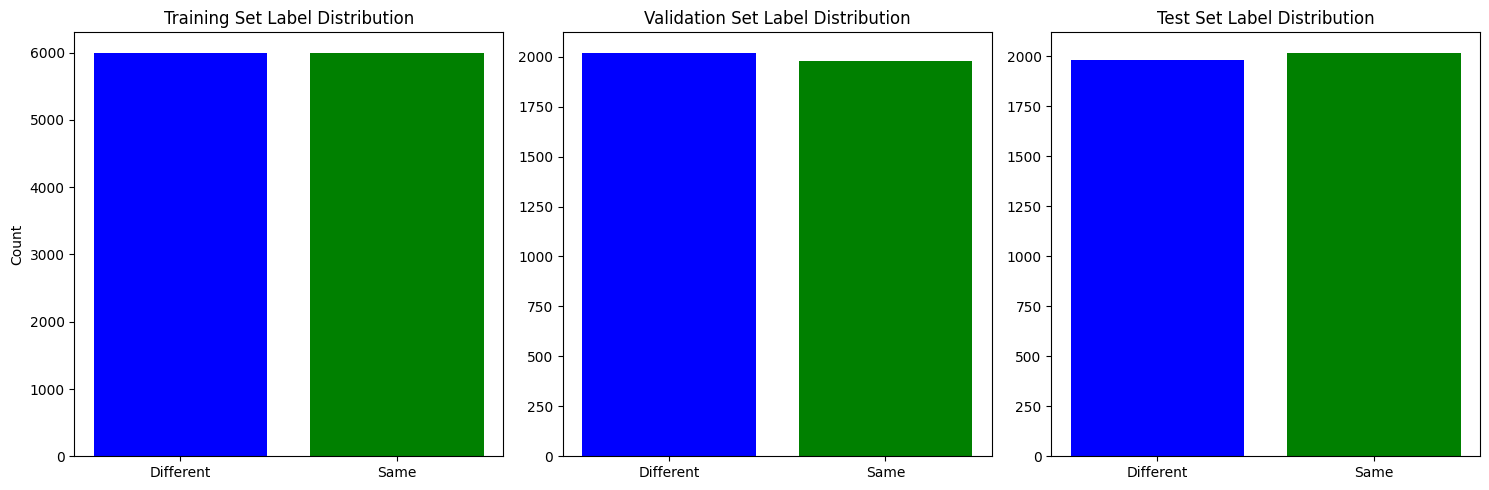

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot label distribution
def plot_label_distribution(train_labels, val_labels, test_labels):
    # Count the number of each label in each dataset
    train_counts = np.bincount(train_labels)
    val_counts = np.bincount(val_labels)
    test_counts = np.bincount(test_labels)

    # Define labels for the bar chart
    categories = ['Different', 'Same']  # Assuming 0 = Different, 1 = Same

    # Set up the figure and axes
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot distribution for training set
    ax[0].bar(categories, train_counts, color=['blue', 'green'])
    ax[0].set_title('Training Set Label Distribution')
    ax[0].set_ylabel('Count')

    # Plot distribution for validation set
    ax[1].bar(categories, val_counts, color=['blue', 'green'])
    ax[1].set_title('Validation Set Label Distribution')

    # Plot distribution for test set
    ax[2].bar(categories, test_counts, color=['blue', 'green'])
    ax[2].set_title('Test Set Label Distribution')

    plt.tight_layout()
    plt.show()

# Example usage
plot_label_distribution(labels_train, labels_val, labels_test)


## Creating dataset using tensorflow dataset pipeline

In [8]:
base_path = 'image'
img_size = (224, 224)
batch_size = 128

def get_images(inputs,outputs):
  img1 = tf.io.read_file(tf.strings.join([base_path, inputs[0]], separator='/'))
  img2 = tf.io.read_file(tf.strings.join([base_path, inputs[1]], separator='/'))

  return (img1,img2),outputs

def process_images(inputs,outputs):
    img1 = tf.image.decode_jpeg(inputs[0], channels=3)
    img1 = tf.image.resize(img1, img_size)

    img2 = tf.image.decode_jpeg(inputs[1], channels=3)
    img2 = tf.image.resize(img2, img_size)

    return (img1,img2),outputs


X1 = X2 = X3 = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices(((input1_train, input2_train), labels_train))
train_dataset = train_dataset.shuffle(len(input1_train))
train_dataset = train_dataset.map(get_images,num_parallel_calls=X1)
train_dataset = train_dataset.map(process_images,num_parallel_calls=X2)
train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.prefetch(buffer_size=X3)


Y1 = Y2 = Y3 = tf.data.experimental.AUTOTUNE
validation_dataset = tf.data.Dataset.from_tensor_slices(((input1_val, input2_val), labels_val))
validation_dataset = validation_dataset.map(get_images,num_parallel_calls=Y1)
validation_dataset = validation_dataset.map(process_images,num_parallel_calls=Y2)
validation_dataset = validation_dataset.batch(batch_size=batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=Y3)


## Creating out simense model

In [9]:
# Define the image size
IMG_SIZE = (224, 224)

# Define the base network (MobileNetV2)
base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # L2 normalization

# Define the final model for feature extraction
feature_model = Model(inputs=base_model.input, outputs=x)

# Siamese Network
def siamese_network():
    input_1 = Input(shape=IMG_SIZE + (3,))
    input_2 = Input(shape=IMG_SIZE + (3,))

    feature_1 = feature_model(input_1)
    feature_2 = feature_model(input_2)

    # Compute the L1 distance between the features
    distance = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([feature_1, feature_2])
    output = Dense(1, activation='sigmoid')(distance)

    model = Model([input_1, input_2], output)
    return model

siamese_model = siamese_network()
siamese_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128)            │     23,849,984 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 128)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ lambda_1[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Callbacks

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose = 1,
)

model_checkpoint = ModelCheckpoint(
    'best_model.weights.h5',      # Filepath to save the model
    monitor='val_loss',    # Monitor the validation loss
    save_best_only=True,   # Save only the best model
    mode='min',
    save_weights_only=True, # Save weights instead of the entire model
)

## Training

In [12]:
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = - alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(fl)
    return focal_loss_fixed

# Replace the current loss function in your model compilation:
siamese_model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])

# Training the model with validation
history = siamese_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopping,model_checkpoint]
)


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5018 - loss: 0.0656 - val_accuracy: 0.5052 - val_loss: 0.0576
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.4988 - loss: 0.0554 - val_accuracy: 0.5105 - val_loss: 0.0547
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5063 - loss: 0.0518 - val_accuracy: 0.5337 - val_loss: 0.0526
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5501 - loss: 0.0481 - val_accuracy: 0.5810 - val_loss: 0.0512
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6111 - loss: 0.0453 - val_accuracy: 0.5893 - val_loss: 0.0494
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6617 - loss: 0.0419 - val_accuracy: 0.6460 - val_loss: 0.0481
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7150 - loss: 0.0395 - val_accuracy: 0.7128 - val_loss: 0.0473
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.7632 - loss: 0.0370 - val_accuracy: 0.6842 - v

## visualization of the training

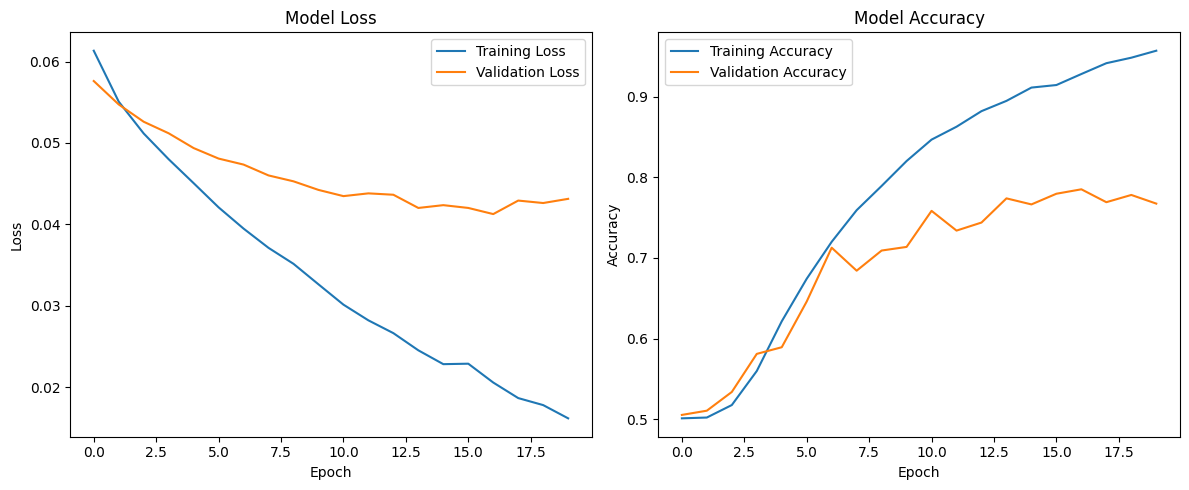

In [14]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_training_history(history)


## Testing

In [15]:
Z1 = Z2 = Z3 = tf.data.experimental.AUTOTUNE
test_dataset = tf.data.Dataset.from_tensor_slices(((input1_test, input2_test), labels_test))
test_dataset = test_dataset.map(get_images,num_parallel_calls=Z1)
test_dataset = test_dataset.map(process_images,num_parallel_calls=Z2)
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=Z3)

# Load the best weights saved by ModelCheckpoint
siamese_model.load_weights('/content/best_model.weights.h5')

# Evaluate the model on the test dataset
test_loss, test_accuracy = siamese_model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 930ms/step - accuracy: 0.8008 - loss: 0.0412
Test Loss: 0.04169430211186409
Test Accuracy: 0.7957500219345093


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step
Visualizing Correct Predictions:


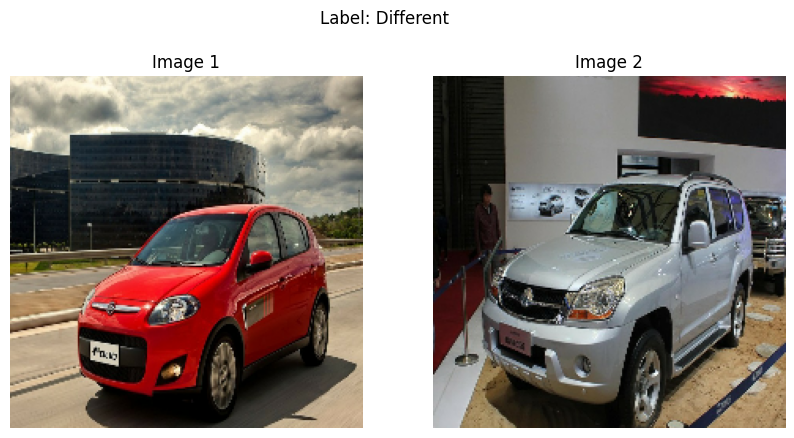

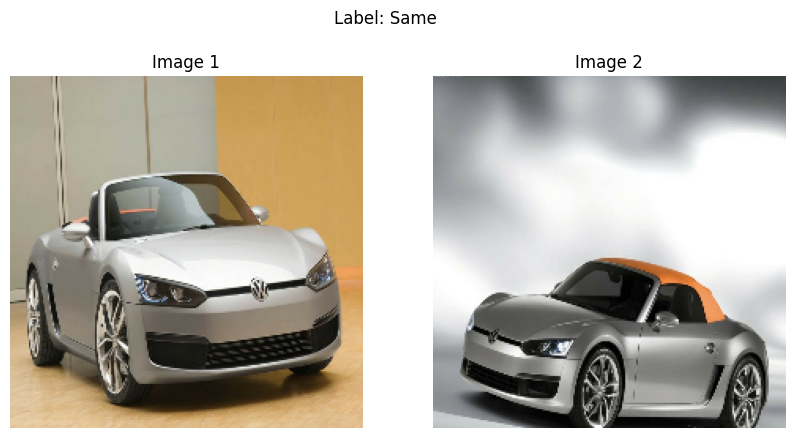

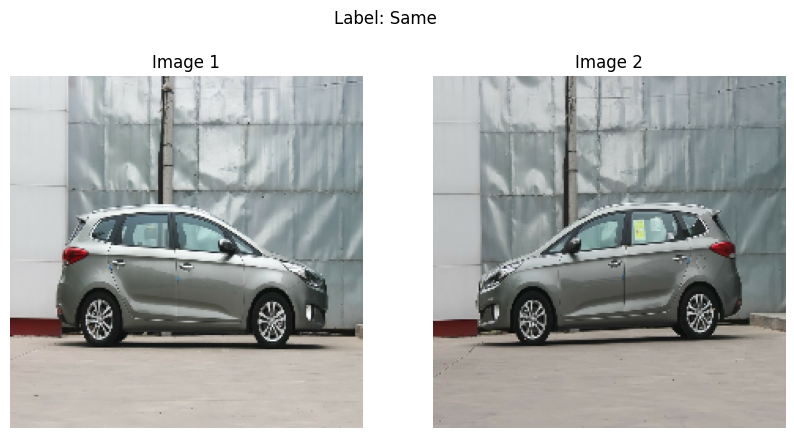

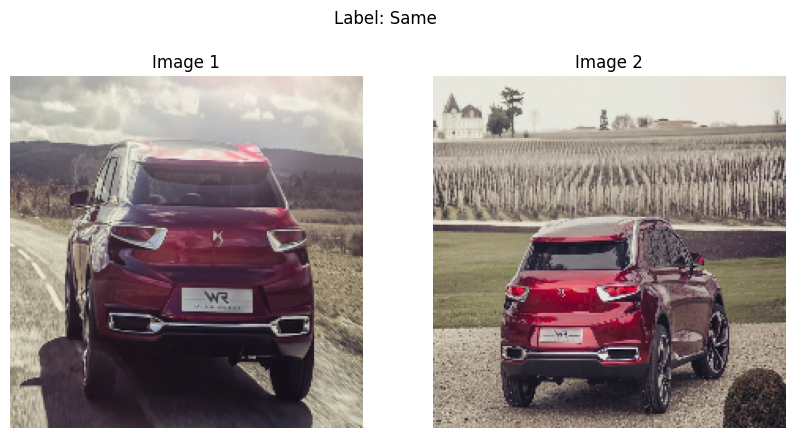

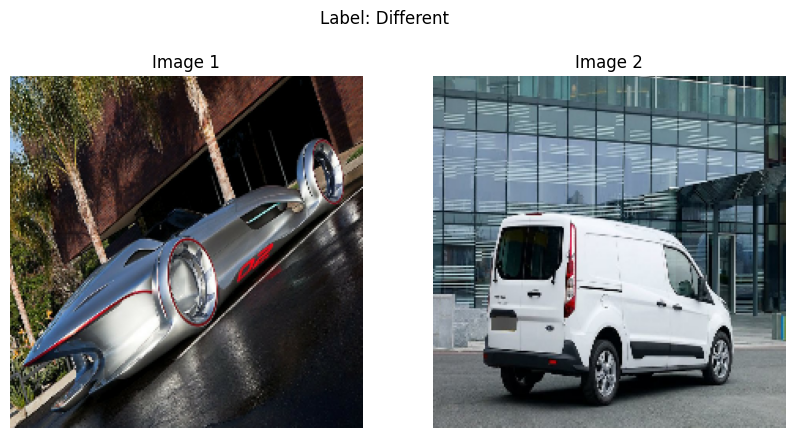

Visualizing Incorrect Predictions:


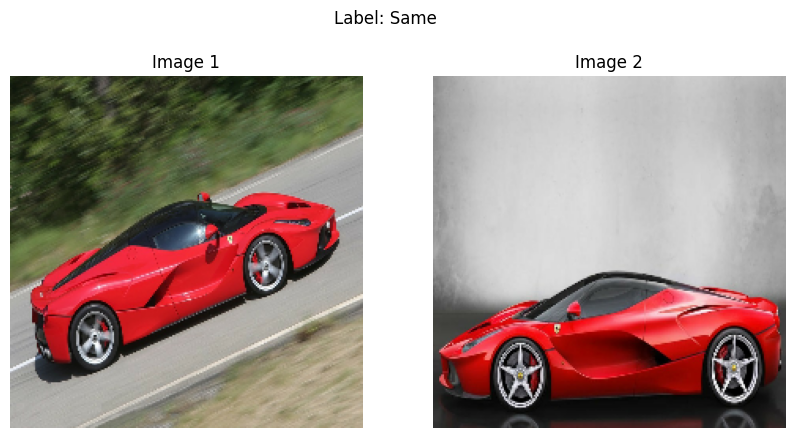

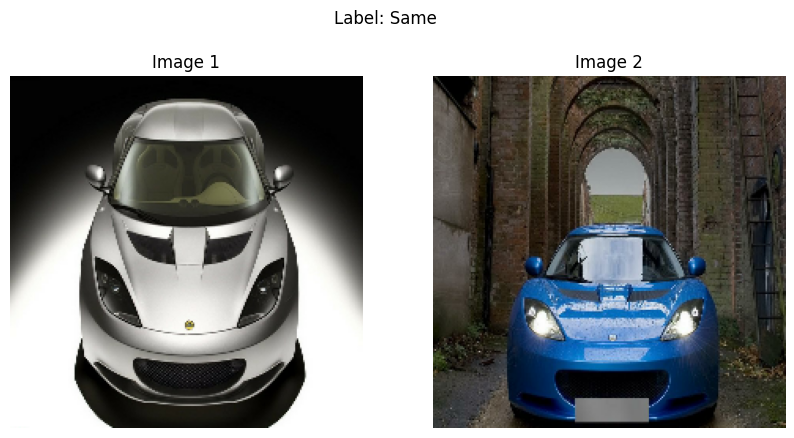

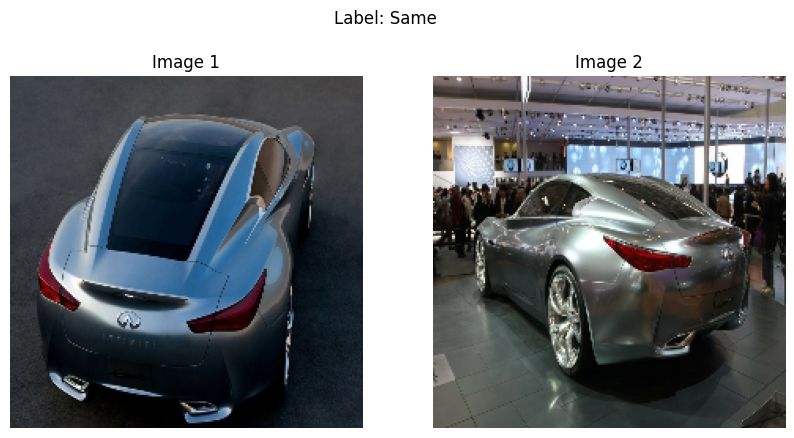

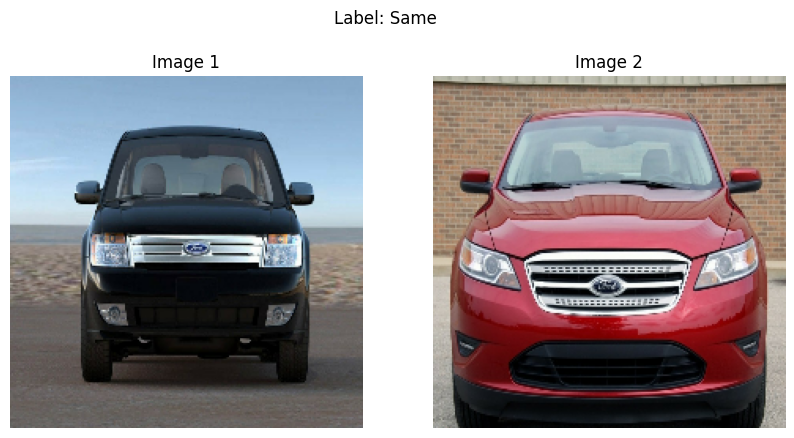

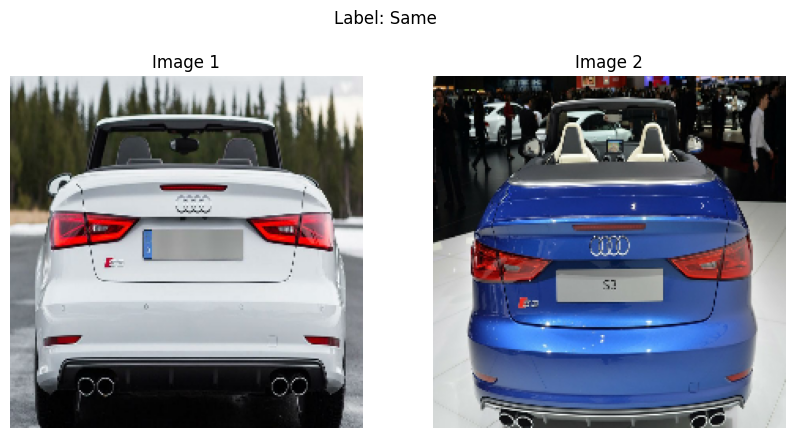

In [16]:
import numpy as np


def display_image_pair(img1_array, img2_array, label):
    # Assuming img1_array and img2_array are NumPy arrays
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display Image 1
    axes[0].imshow(img1_array.astype('uint8'))
    axes[0].axis('off')
    axes[0].set_title('Image 1')

    # Display Image 2
    axes[1].imshow(img2_array.astype('uint8'))
    axes[1].axis('off')
    axes[1].set_title('Image 2')

    # Title with the label
    plt.suptitle(f'Label: {"Same" if label == 1 else "Different"}')
    plt.show()


# Function to visualize correct and incorrect predictions
def visualize_predictions(model, test_dataset, num_visualize=5):
    correct_predictions = []
    incorrect_predictions = []

    # Iterate through the test dataset
    for batch in test_dataset:
        (img1_batch, img2_batch), labels_batch = batch
        predictions = model.predict([img1_batch, img2_batch])
        predictions = np.round(predictions).astype(int).flatten()  # Rounding predictions to 0 or 1

        for i in range(len(predictions)):
            if predictions[i] == labels_batch[i]:
                correct_predictions.append((img1_batch[i], img2_batch[i], labels_batch[i]))
            else:
                incorrect_predictions.append((img1_batch[i], img2_batch[i], labels_batch[i]))

            # Break if we have enough examples to visualize
            if len(correct_predictions) >= num_visualize and len(incorrect_predictions) >= num_visualize:
                break
        if len(correct_predictions) >= num_visualize and len(incorrect_predictions) >= num_visualize:
            break

    # Visualize correct predictions
    print("Visualizing Correct Predictions:")
    for img1, img2, label in correct_predictions[:num_visualize]:
        display_image_pair(img1.numpy(), img2.numpy(), label)

    # Visualize incorrect predictions
    print("Visualizing Incorrect Predictions:")
    for img1, img2, label in incorrect_predictions[:num_visualize]:
        display_image_pair(img1.numpy(), img2.numpy(), label)

# Call the function to visualize predictions
visualize_predictions(siamese_model, test_dataset, num_visualize=5)
